# Chapter 3 Code

Covers code for Chapter 3, "The Versatility of Autoencoders", of *Modern Deep Learning Design and Application*. *Note: the notebook is designed to run sequentially; some variables may be not defined if you run cells out of order.*

---

## Installing + Importing Libraries

In [1]:
# array processing + math
import numpy as np
import pandas as pd
import scipy
import math
import sklearn

# plotting & visuals
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# looping - very helpful for data manpulation scripts
from tqdm.notebook import tqdm

# deep learning staple libraries
# !pip install tensorflow # install if necessary
import sklearn
import tensorflow as tf
from tensorflow import keras

# keras specifics
import keras.layers as L
import keras.backend as K
from keras.utils import plot_model

---

## Loading Chapter Dataset

The chapter dataset is custom-modified version of the Stanford dogs and cats dataset.

Download the `zipped_dogs_cats_data.zip` file and load it using the below script. This reads in data from the data and converts it into a TensorFlow dataset. The `max_lim` variable allows you to specify the number of data instances for each gender in the dataset.

You can use this dummy dataset to perform pretraining.

In [2]:
image_directories, labels = [], []

num_cats, num_dogs = 0, 0
max_lim = 5000

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if dirname == '/kaggle/input/dogs-and-cats-dataset/data/cat' and num_cats != max_lim:
            image_directories.append(os.path.join(dirname, filename))
            labels.append(0)
            num_cats += 1
            
        elif dirname == '/kaggle/input/dogs-and-cats-dataset/data/dog' and num_dogs != max_lim:
            image_directories.append(os.path.join(dirname, filename))
            labels.append(1)
            num_dogs += 1
            
    if num_cats == max_lim and num_dogs == max_lim: break

arr = np.array(list(zip(image_directories, labels)))
np.random.shuffle(arr)
unparsed = tf.data.Dataset.from_tensor_slices((arr[:,0],arr[:,1].astype(np.int)))

def parse_files(filename, label): 
    raw_image = tf.io.read_file(filename) 
    image = tf.image.decode_png(raw_image, channels=3) 
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [64,64]) 
    return image, label 

data = unparsed.map(parse_files)
data = data.batch(8)

def ae_parse_files(filename, label): 
    raw_image = tf.io.read_file(filename) 
    image = tf.image.decode_png(raw_image, channels=3) 
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [64,64]) 
    return image, image 

ae_data = unparsed.map(ae_parse_files)
ae_data = ae_data.batch(8)

---

## Autoencoder Implementation Design

### Autoencoders for Tabular Data

Generate structured-form data from MNIST data.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(len(x_train),784)/255
x_test = x_test.reshape(len(x_test),784)/255

11493376/11490434 [==============================] - 0s 0us/step


Defining an autoencoder sequentially.

In [4]:
import keras.layers as L
from keras.models import Sequential

# define architecture
model = Sequential()
model.add(L.Input((784,)))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(64, activation='relu'))
model.add(L.Dense(32, activation='relu'))
model.add(L.Dense(64, activation='relu'))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(784, activation='sigmoid'))

# compile
model.compile(optimizer='adam',
              loss='binary_crossentropy')

# fit
model.fit(x_train, x_train, epochs=1)

# plot model
# plot_model(ae, show_shapes=True)

1875/1875 [==============================] - 10s 5ms/step - loss: 0.1856


Defining an autoencoder with compartmentalized design.

In [5]:
from keras.models import Model

# define architecture components
encoder = Sequential(name='encoder')
encoder.add(L.Input((784,)))
encoder.add(L.Dense(256, activation='relu'))
encoder.add(L.Dense(64, activation='relu'))
encoder.add(L.Dense(32, activation='relu')) 

decoder = Sequential(name='decoder')
decoder.add(L.Input((32,)))
decoder.add(L.Dense(64, activation='relu'))
decoder.add(L.Dense(256, activation='relu'))
decoder.add(L.Dense(784, activation='sigmoid'))

# define model archtitecutre from components
ae_input = L.Input((784,), name='input')
ae_encoder = encoder(ae_input)
ae_decoder = decoder(ae_encoder)
ae = Model(inputs = ae_input,
           outputs = ae_decoder)

# compile
ae.compile(optimizer='adam',
           loss='binary_crossentropy')

# fit
ae.fit(x_train, x_train, epochs=1)

# plot model
# plot_model(ae, show_shapes=True)

# get encoder representation for one example input
encoder.predict(x_train[0:1])

1875/1875 [==============================] - 10s 5ms/step - loss: 0.1919


array([[ 6.524593 ,  2.6265604,  0.       ,  8.233377 ,  7.651691 ,
         1.6475571, 13.561642 ,  6.422927 ,  6.61655  ,  0.       ,
         2.5197434,  0.       ,  8.793349 ,  7.4959064,  6.2363844,
         5.129163 ,  2.9555082,  8.353191 ,  8.515166 ,  4.4038424,
         6.1644526,  0.       ,  6.70263  , 13.952887 ,  3.3447397,
         6.7221   , 15.21405  ,  1.8237884,  5.0256553,  4.2876725,
         0.       ,  0.       ]], dtype=float32)

### Autoencoders for Image Data

Convolutional autoencoder without pooling.

In [6]:
# define architecture components
encoder = Sequential()
encoder.add(L.Input((64, 64, 3)))
encoder.add(L.Conv2D(8, (3, 3), activation='relu'))
encoder.add(L.Conv2D(8, (3, 3), activation='relu'))
encoder.add(L.Conv2D(16, (3, 3), activation='relu'))
encoder.add(L.Conv2D(16, (3, 3), activation='relu'))
encoder.add(L.Conv2D(32, (3, 3), activation='relu'))
encoder.add(L.Conv2D(32, (3, 3), activation='relu'))

decoder = Sequential()
decoder.add(L.Input((52, 52, 32)))
decoder.add(L.Conv2DTranspose(32, (3, 3), activation='relu'))
decoder.add(L.Conv2DTranspose(32, (3, 3), activation='relu'))
decoder.add(L.Conv2DTranspose(16, (3, 3), activation='relu'))
decoder.add(L.Conv2DTranspose(16, (3, 3), activation='relu'))
decoder.add(L.Conv2DTranspose(8, (3, 3), activation='relu'))
decoder.add(L.Conv2DTranspose(8, (3, 3), activation='relu'))
decoder.add(L.Conv2D(3, (1, 1), activation='sigmoid'))

# define model archtitecture from components
ae_input = L.Input((64,64,3), name='input')
ae_encoder = encoder(ae_input)
ae_decoder = decoder(ae_encoder)
ae = Model(inputs = ae_input,
           outputs = ae_decoder)

# compile
ae.compile(optimizer='adam',
           loss='binary_crossentropy')

# fit
ae.fit(ae_data, epochs=1)

# plot model
# plot_model(ae, show_shapes=True)

1249/1249 [==============================] - 248s 197ms/step - loss: 0.5875


Convolutional autoencoder vector-bottleneck design

In [7]:
# DEFINE ARCHITECTURAL COMPONENTS
# encoder
encoder = Sequential()
encoder.add(L.Input((64, 64, 3)))

#convolutional component
encoder.add(L.Conv2D(8, (3,3)))
encoder.add(L.Conv2D(16, (3,3))) 

#flattening and processing
encoder.add(L.Flatten())
encoder.add(L.Dense(256, activation='relu'))
encoder.add(L.Dense(32))

# decoder
decoder = Sequential()
decoder.add(L.Input((32,)))

#processing and reshaping
decoder.add(L.Dense(256, activation='relu')) 
decoder.add(L.Dense(57_600, activation='relu'))
decoder.add(L.Reshape((60, 60, 16)))

#applying transpose-convolutional layers
decoder.add(L.Conv2DTranspose(16, (3,3)))
decoder.add(L.Conv2DTranspose(8, (3,3)))
decoder.add(L.Conv2D(3, (1,1)))

# DEFINE MODEL ARCHITECTURE FROM COMPONENTS
ae_input = L.Input((64,64,3), name='input')
ae_encoder = encoder(ae_input)
ae_decoder = decoder(ae_encoder)
ae = Model(inputs = ae_input,
           outputs = ae_decoder)

# COMPILE
ae.compile(optimizer='adam',
           loss='binary_crossentropy')

# FIT
ae.fit(ae_data, epochs=1)

# plot model
# plot_model(ae, show_shapes=True)

1249/1249 [==============================] - 240s 191ms/step - loss: 1.0912


Convolutional autoencoder with pooling and padding.

In [8]:
# DEFINE ARCHITECTURAL COMPONENTS
# encoder
encoder = Sequential(name='encoder')
encoder.add(L.Input((64, 64, 3)))

#convolutional component
for i in range(3):
    encoder.add(L.Conv2D(2**(i+3), (3,3),
                padding='same'))
    encoder.add(L.Conv2D(2**(i+3), (3,3),
                padding='same'))
    encoder.add(L.MaxPooling2D((2,2)))

#flattening and processing
encoder.add(L.Flatten())
encoder.add(L.Dense(256, activation='relu'))
encoder.add(L.Dense(32))

# decoder
decoder = Sequential(name='decoder')
decoder.add(L.Input((32,)))

#processing and reshaping
decoder.add(L.Dense(256, activation='relu')) 
decoder.add(L.Dense(2048, activation='relu'))
decoder.add(L.Reshape((8, 8, 32)))

#applying transpose-convolutional layers
for i in range(3):
    decoder.add(L.UpSampling2D((2,2)))
    decoder.add(L.Conv2DTranspose(2**(3-i), (3,3),
                padding='same'))
    decoder.add(L.Conv2DTranspose(2**(3-i), (3,3),
                padding='same'))

#adding additional layer to collapse channels
decoder.add(L.Conv2D(3, (1,1)))

# DEFINE MODEL ARCHITECTURE FROM COMPONENTS
ae_input = L.Input((64,64,3), name='input')
ae_encoder = encoder(ae_input)
ae_decoder = decoder(ae_encoder)
ae = Model(inputs = ae_input,
           outputs = ae_decoder)

# COMPILE
ae.compile(optimizer='adam',
           loss='binary_crossentropy')

# FIT
ae.fit(ae_data, epochs=1)

# plot model
# plot_model(ae, show_shapes=True)

1249/1249 [==============================] - 83s 66ms/step - loss: 0.9351


---

## Autoencoder Applications

### Using Autoencoders for Denoising

Inject noise into model via noise layer.

In [9]:
# define denoising autoencoder architecture
ae_input = L.Input((64,64,3), name='input')
ae_noising = L.GaussianNoise(0.1, name='noising')(ae_input)
ae_encoder = encoder(ae_noising)
ae_decoder = decoder(ae_encoder)
ae = Model(inputs = ae_input,
           outputs = ae_decoder)

# compile
ae.compile(optimizer='adam',
           loss='binary_crossentropy')

# fit
ae.fit(ae_data, epochs=1)

# extract noise-inducing layer
final_dae_input = L.Input((64,64,3), name='input')
final_dae_encoder = ae.get_layer('encoder')(final_dae_input)
final_dae_decoder = ae.get_layer('decoder')(final_dae_encoder)
final_dae = Model(inputs=final_dae_input,
                  outputs=final_dae_decoder)

1249/1249 [==============================] - 85s 67ms/step - loss: 0.6304


Inject noise into dataset via parsing function.

In [10]:
# load data
def dae_parse_file(filename, label):
    raw_image = tf.io.read_file(filename) 
    image = tf.image.decode_png(raw_image, channels=3) 
    image = tf.image.convert_image_dtype(image, tf.float32)
    orig_img = tf.image.resize(image, [64,64]) 
    rand_img = tf.image.random_brightness(orig_img, 0.01)
    rand_img = tf.image.random_jpeg_quality(rand_img, 80, 100)
    return rand_img, orig_img
dae_data = unparsed.map(dae_parse_file)
dae_data = dae_data.batch(8)

# define architecture
ae_input = L.Input((64,64,3), name='input')
ae_encoder = encoder(ae_input)
ae_decoder = decoder(ae_encoder)
ae = Model(inputs = ae_input,
           outputs = ae_decoder)

# compile
ae.compile(optimizer='adam',
           loss='binary_crossentropy')

# fit
ae.fit(dae_data, epochs=1)

1249/1249 [==============================] - 86s 68ms/step - loss: 0.6139


Inject noise into dataset via Image Data Generator

In [11]:
# load data
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(rescale=1./255) # use default augmentation params
idg_flow = idg.flow_from_directory(
    directory = '/kaggle/input/dogs-and-cats-dataset/data',
    class_mode = 'input',
    target_size = (64,64),
)

# define architecture
ae_input = L.Input((None,None,3), name='input')
ae_resize = L.experimental.preprocessing.Resizing
ae_encoder = encoder(ae_input)
ae_decoder = decoder(ae_encoder)
ae = Model(inputs = ae_input,
           outputs = ae_decoder)

# compile
ae.compile(optimizer='adam',
           loss='binary_crossentropy')

# fit
ae.fit(idg_flow, epochs=1)

Found 10000 images belonging to 2 classes.
313/313 [==============================] - 75s 236ms/step - loss: 0.6027


### Using Autoencoders for Pretraining

In [12]:
# creating the encoder
encoder = Sequential(name='encoder')
encoder.add(L.Input((784,)))
encoder.add(L.Dense(256, activation='relu'))
encoder.add(L.Dense(64, activation='relu'))
encoder.add(L.Dense(32, activation='relu'))

# creating the decoder
decoder = Sequential(name='decoder')
decoder.add(L.Input((32,)))
decoder.add(L.Dense(64, activation='relu'))
decoder.add(L.Dense(256, activation='relu'))
decoder.add(L.Dense(784, activation='sigmoid'))

# creating the autoencoder
ae_input = L.Input((784,), name='input')
ae_noising = L.GaussianNoise(0.1, name='noising')(ae_input)
ae_encoder = encoder(ae_noising)
ae_decoder = decoder(ae_encoder)
ae = Model(inputs = ae_input,
           outputs = ae_decoder,
           name='denoising-autoencoder')

# compile
ae.compile(optimizer='adam',
           loss='binary_crossentropy')

# fit on reshaped structured MNIST data
ae.fit(x_train, x_train, epochs=1)

# build submodel to process outputs of encoded features
process = Sequential(name='processing')
process.add(L.Input((32,)))
process.add(L.Dense(16, activation='relu'))
process.add(L.Dense(10, activation='sigmoid'))

# overarching model for supervised task
inp = L.Input((784,), name='input')
encoding = encoder(inp)
processing = process(encoding)
ult_model = Model(inputs=inp,
                  outputs=processing)

# compile
ult_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy')

# fit
ult_model.fit(x_train, y_train, epochs=1)

1875/1875 [==============================] - 5s 2ms/step - loss: 1.1017


### Using Autoencoders for Dimensionality Reduction

In [13]:
# define components
encoder = Sequential(name='encoder')
encoder.add(L.Input((784,)))
encoder.add(L.Dense(256, activation='selu'))
encoder.add(L.Dense(128, activation='selu'))
encoder.add(L.Dense(64, activation='selu'))
encoder.add(L.Dense(32, activation='selu'))
encoder.add(L.Dense(20, activation='selu')) 

decoder = Sequential(name='decoder')
decoder.add(L.Input((20,)))
decoder.add(L.Dense(32, activation='selu'))
decoder.add(L.Dense(64, activation='selu'))
decoder.add(L.Dense(128, activation='selu'))
decoder.add(L.Dense(256, activation='selu'))
decoder.add(L.Dense(784, activation='sigmoid'))

# define model archtitecture from components
ae_input = L.Input((784,), name='input')
ae_encoder = encoder(ae_input)
ae_decoder = decoder(ae_encoder)
ae = Model(inputs = ae_input,
           outputs = ae_decoder)

# compile
ae.compile(optimizer='adam',
           loss='binary_crossentropy')

# fit
ae.fit(x_train, x_train, epochs=5)

# visualize reductions
pred = encoder.predict(x_train)

Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1880
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1237
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1139
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1105
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1078


Visualize dimensionality reduction even further with t-SNE. (Using only autoencoders for visualization is likely not a good idea because performance will be too poor for the visualization to mean anything.) Autoencoder learns to visibly separate images into distinct clusters.

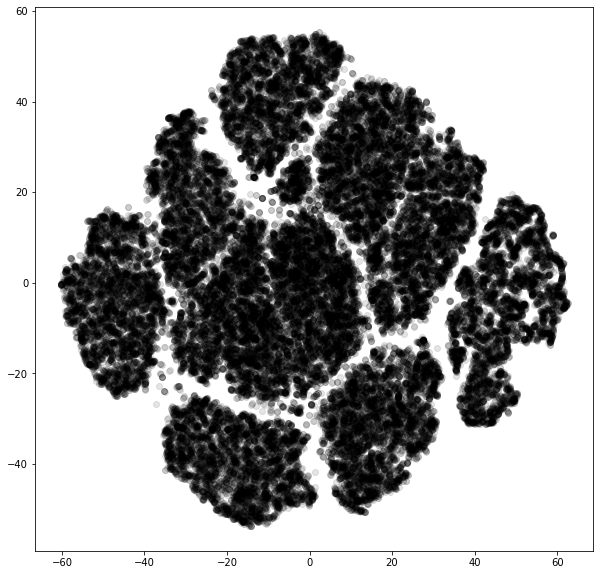

In [14]:
from sklearn import manifold
reductions = manifold.TSNE().fit_transform(pred)
plt.figure(figsize=(10,10))
plt.scatter(reductions[:,0], reductions[:,1], color='black', alpha=0.1)
plt.show()

### Using Autoencoders for Feature Generation

Simpler feature generation architecture.

In [15]:
# build feature concatenation model
inp = L.Input((784,))
encoding = encoder(inp)
merge = L.Concatenate()([inp, encoding])
dense1 = L.Dense(256, activation='relu')(merge)
dense2 = L.Dense(64, activation='relu')(dense1)
output = L.Dense(10, activation='softmax')(dense2)
model = Model(inputs=inp, outputs=output)

# lock encoder trainability
encoding.trainable = False

# compile + train
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy')
model.fit(x_train, y_train, epochs=1)

1875/1875 [==============================] - 10s 5ms/step - loss: 0.3077


Complex feature generation architecture.

In [16]:
inp = L.Input((784,))
encoding = encoder(inp)

# processing the input independently
p_inp_1 = L.Dense(256, activation='relu')(inp)
p_inp_2 = L.Dense(128, activation='relu')(p_inp_1)

# processing the encoder output independently
p_encoding_1 = L.Dense(32, activation='relu')(encoding)
p_encoding_2 = L.Dense(32, activation='relu')(p_encoding_1)

# merge and process
merge = L.Concatenate()([p_inp_2,
                         p_encoding_2])
dense1 = L.Dense(256, activation='relu')(merge)
dense2 = L.Dense(64, activation='relu')(dense1)
output = L.Dense(10, activation='softmax')(dense2)

# aggregate into model
model = Model(inputs=inp, outputs=output)

# freeze encoder weights
encoding.trainable = False

# compile + train
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy')
model.fit(x_train, y_train, epochs=1)

1875/1875 [==============================] - 10s 5ms/step - loss: 0.2304


### Using Variational Autoencoders for Data Generation

In [17]:
# encoder
enc_inputs = L.Input((784,), name='input')
enc_dense1 = L.Dense(256, activation='relu',
                     name='dense1')(enc_inputs)
enc_dense2 = L.Dense(128, activation='relu',                 
                     name='dense2')(enc_dense1)
means = L.Dense(32, name='means')(enc_dense2)
log_stds = L.Dense(32, name='log-stds')(enc_dense2)

def sampling(args):
    means, log_stds = args
    eps = tf.random.normal(shape=(tf.shape(means)[0], 32),
                           mean=0, stddev=0.15)
    return means + tf.exp(log_stds) * eps

x = L.Lambda(sampling, name='sampling')([means, log_stds])

encoder = keras.Model(inputs=enc_inputs, 
                      outputs=[means, log_stds, x],
                      name='encoder')

# decoder
dec_inputs = L.Input((32,), name='input')
dec_dense1 = L.Dense(128, activation='relu',               
                     name='dense1')(dec_inputs)
dec_dense2 = L.Dense(256, activation='relu',
                     name='dense2')(dec_dense1)
output = L.Dense(784, activation='sigmoid',
                 name='output')(dec_dense2)
decoder = keras.Model(inputs=dec_inputs, 
                      outputs=output, 
                      name='decoder')

# construct vae
vae_inputs = enc_inputs
encoded = encoder(vae_inputs)
decoded = decoder(encoded[2])
vae = keras.Model(inputs=vae_inputs, 
                  outputs=decoded,
                  name='vae')

# build loss function
from keras.losses import binary_crossentropy
reconst_loss = binary_crossentropy(vae_inputs, decoded)
kl_loss = 1 + log_stds - tf.square(means) - tf.exp(log_stds)
kl_loss = tf.square(tf.reduce_sum(kl_loss, axis=-1))
vae_loss = tf.reduce_mean(reconst_loss + kl_loss)

# compile model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# fit
vae.fit(x_train, x_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3887
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2547
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2479
Epoch 4/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2465
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2460


Demonstrate predictions.

<Figure size 432x288 with 0 Axes>

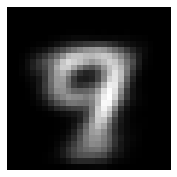

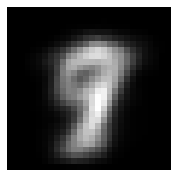

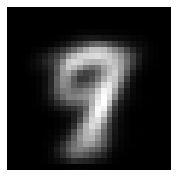

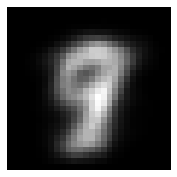

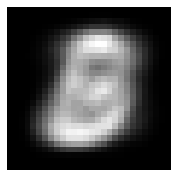

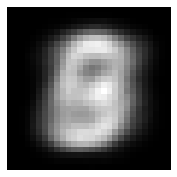

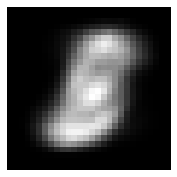

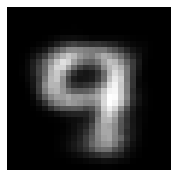

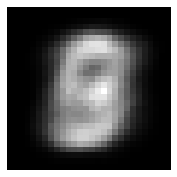

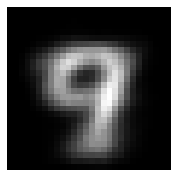

In [18]:
# generate base representation to
rep = encoder.predict(x_test)[2][0]

# show reconstructions by adding noise
# better reconstructions come with more training
plt.set_cmap('gray')
for i in range(10):
    plt.figure(figsize=(3,3))
    arr = rep + np.random.normal(size=(32,))/3
    img = decoder.predict(arr.reshape(1,32)).reshape(28,28)
    plt.axis('off')
    plt.imshow(img)

---

## Case Study: TabNet

Install TabNet library.

In [19]:
!pip install tabnet

In [20]:
from tabnet import TabNetClassifier
model = TabNetClassifier(feature_columns=None,
                         num_classes=10,
                         num_features=784,
                         feature_dim=32,
                         output_dim=16)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5) # train for more epochs for better performance

[TabNet]: 16 features will be used for decision steps.
Epoch 1/5
1875/1875 [==============================] - 61s 28ms/step - loss: 2.1054 - accuracy: 0.2353
Epoch 2/5
1875/1875 [==============================] - 53s 28ms/step - loss: 1.8070 - accuracy: 0.3600
Epoch 3/5
1875/1875 [==============================] - 54s 29ms/step - loss: 1.7030 - accuracy: 0.3832
Epoch 4/5
1875/1875 [==============================] - 55s 29ms/step - loss: 1.9494 - accuracy: 0.2898
Epoch 5/5
1875/1875 [==============================] - 55s 29ms/step - loss: 1.9462 - accuracy: 0.2946


---

## Versions

See versions for all libraries used if you run into any errors.

In [21]:
!pip list

Package                        Version             Location
------------------------------ ------------------- --------------
absl-py                        0.12.0
adal                           1.2.6
affine                         2.3.0
aiobotocore                    1.3.0
aiohttp                        3.7.4
aiohttp-cors                   0.7.0
aioitertools                   0.7.1
aioredis                       1.3.1
albumentations                 0.5.2
alembic                        1.5.8
allennlp                       2.3.0
altair                         4.1.0
annoy                          1.17.0
ansiwrap                       0.8.4
appdirs                        1.4.4
argon2-cffi                    20.1.0
arrow                          1.0.3
arviz                          0.11.2
asn1crypto                     1.4.0
astunparse                     1.6.3
async-generator                1.10
async-timeout                  3.0.1
attrs                          20.3.0
audioread          

---